In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re
from copy import deepcopy

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "DejaVu Sans"
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
filename = '../data/20250304_Hansenlab_chromatin_dynamics_all-data.h5'
data       = nl.io.load.hdf5(filename)['data']

# Prep
assemble fits (used for plotting MSDs) and load fit results

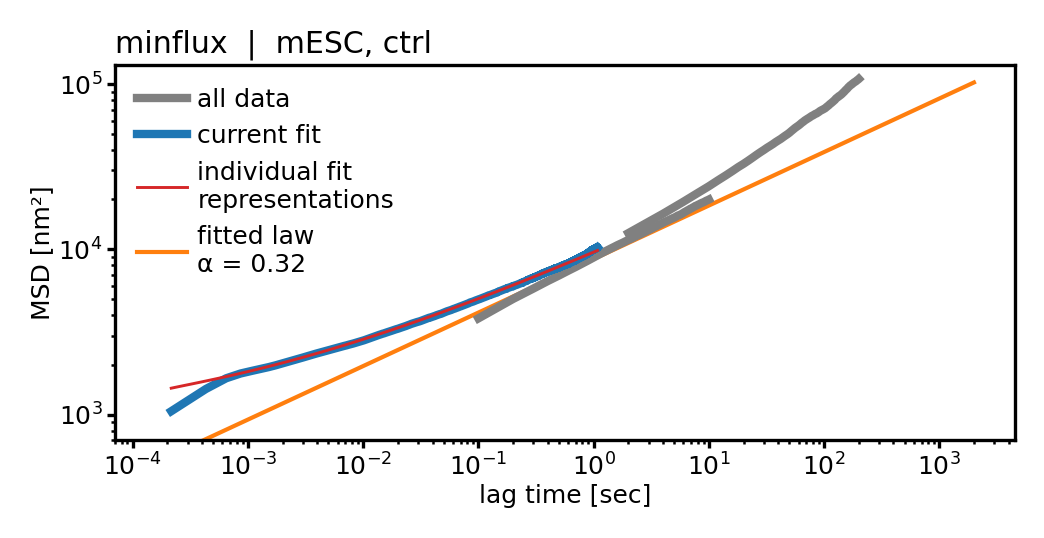

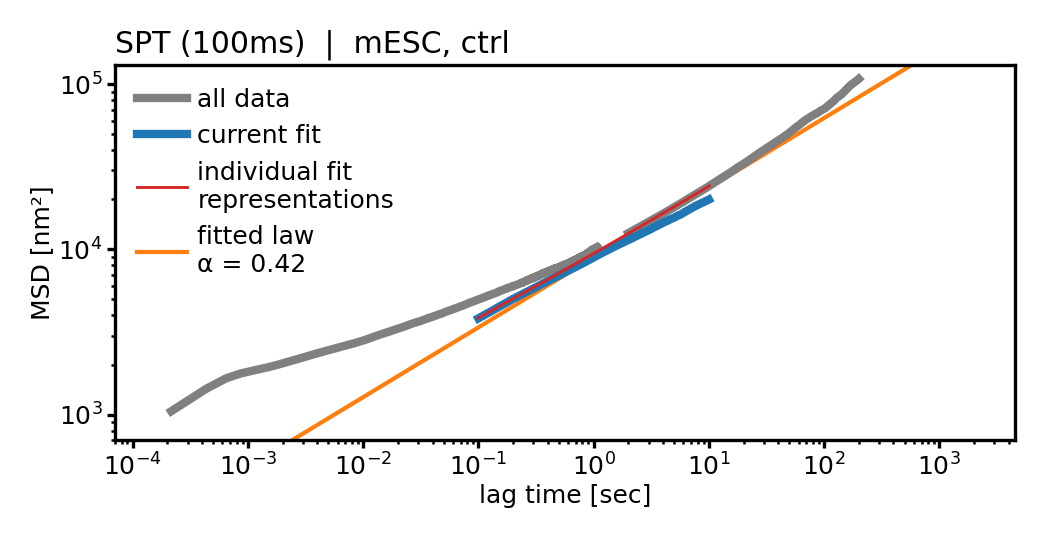

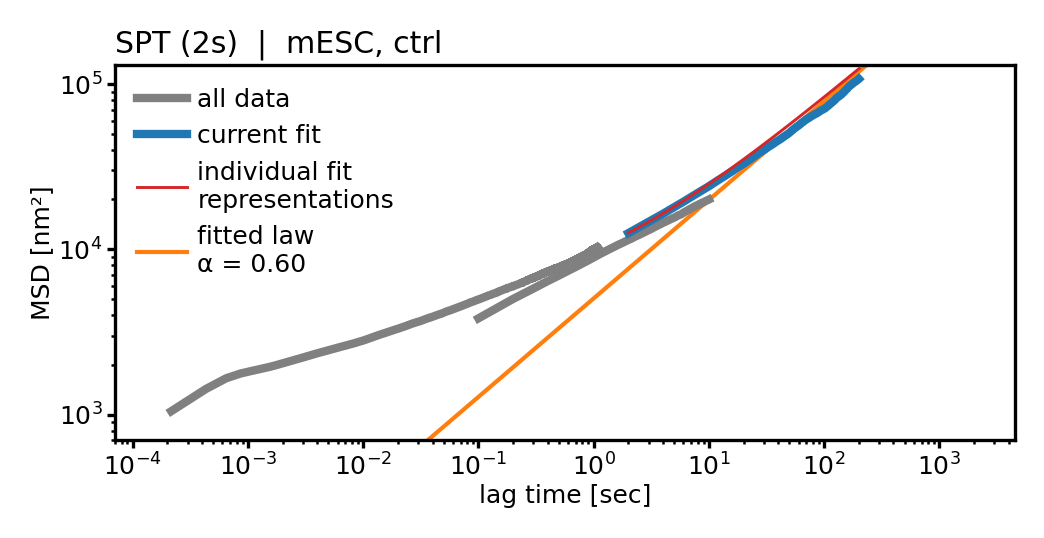

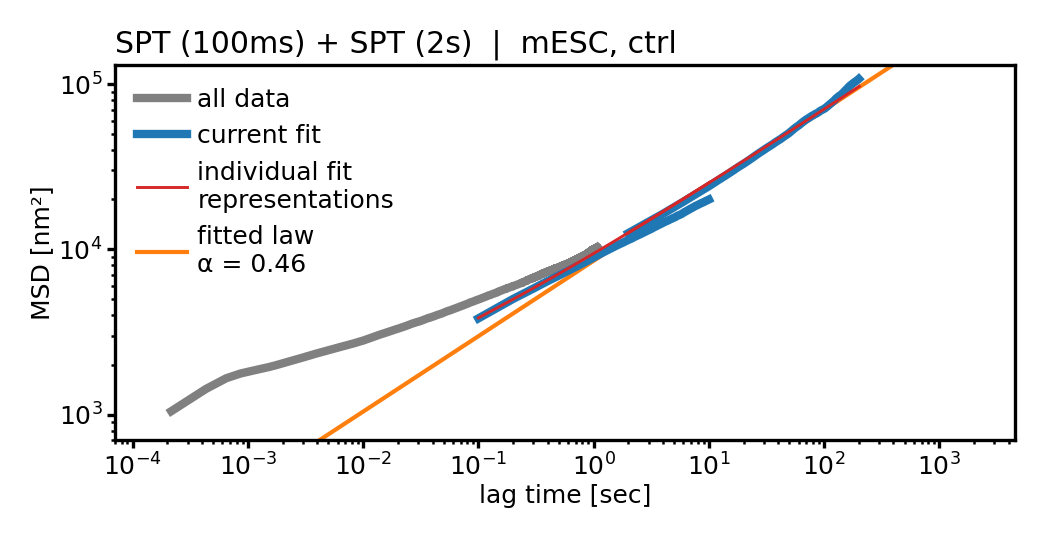

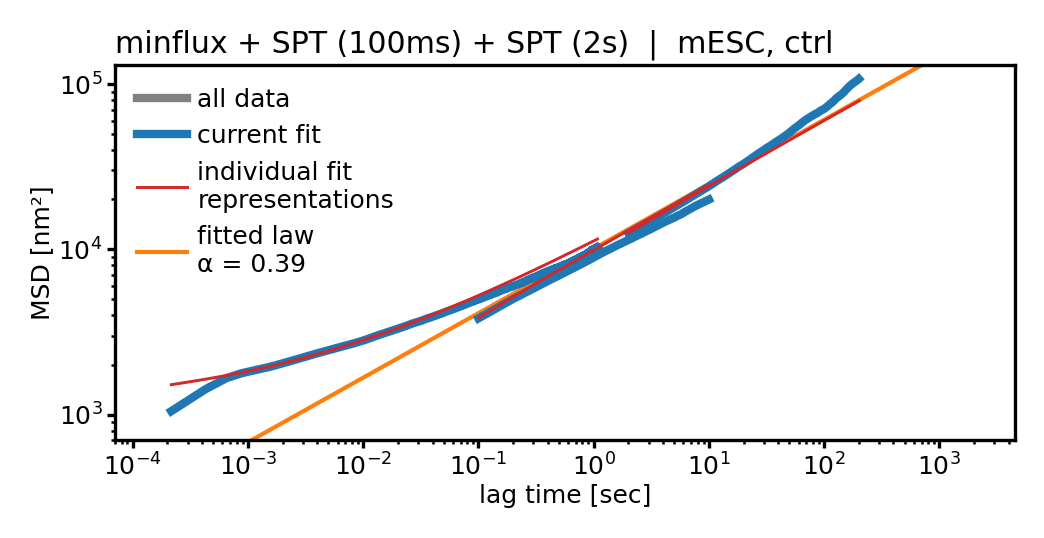

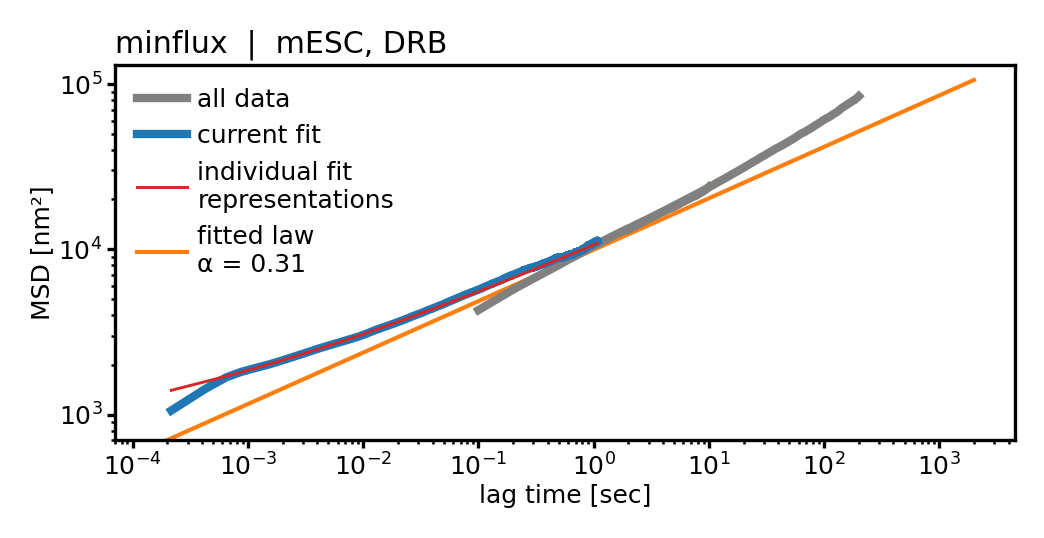

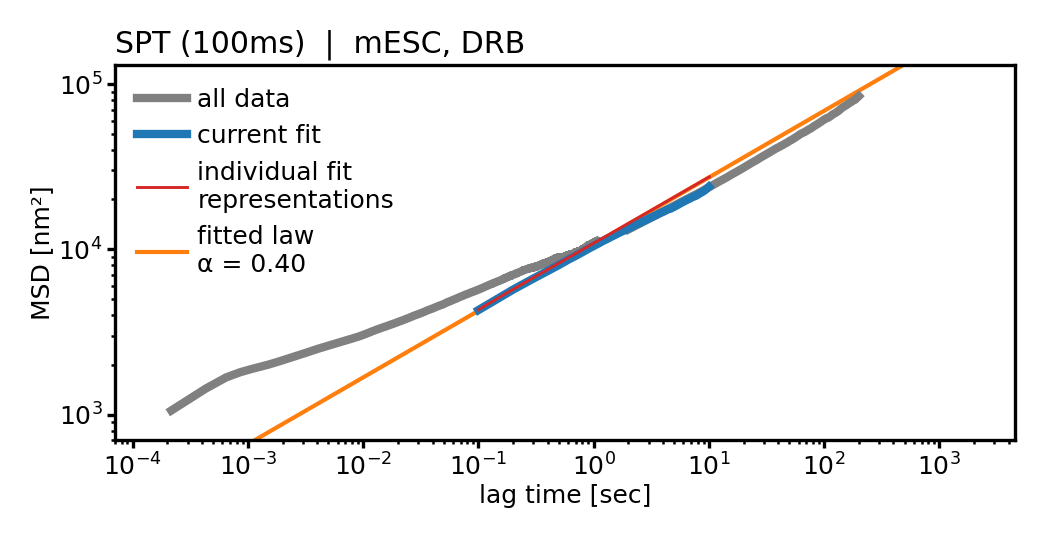

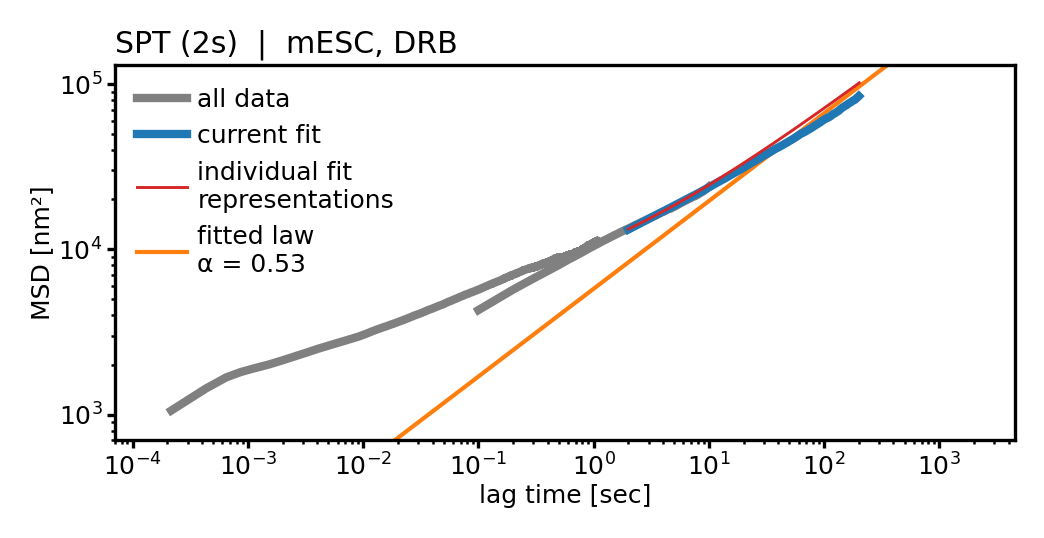

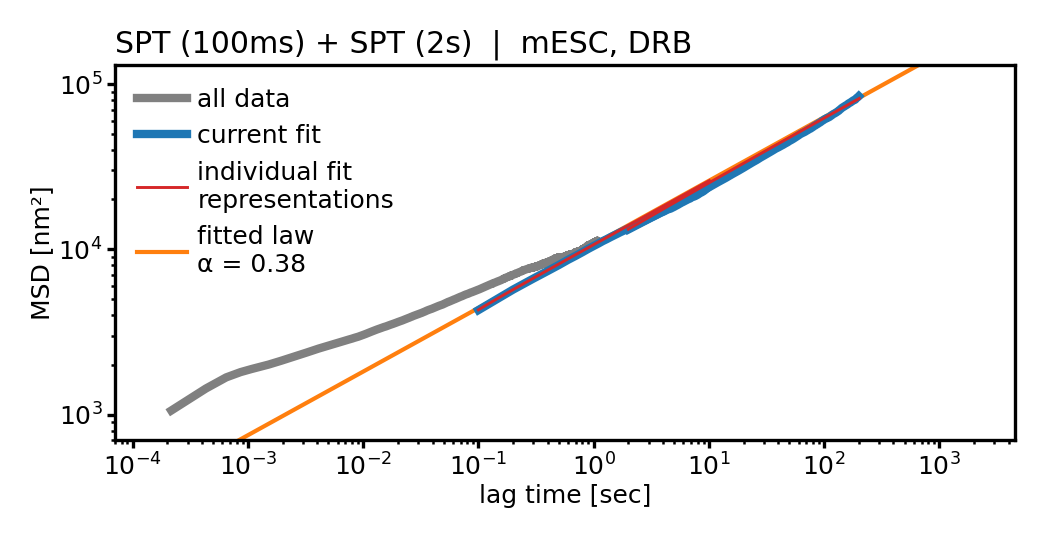

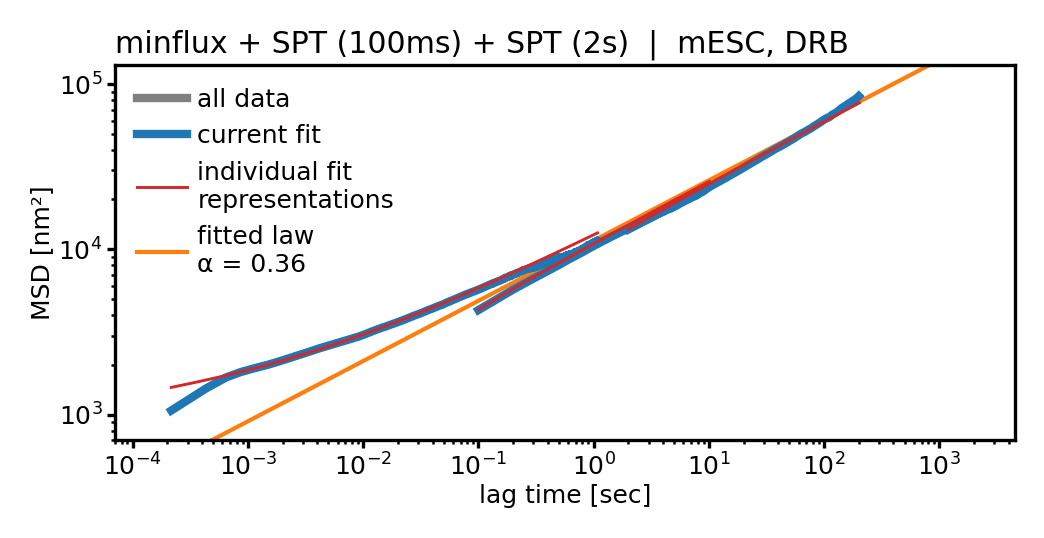

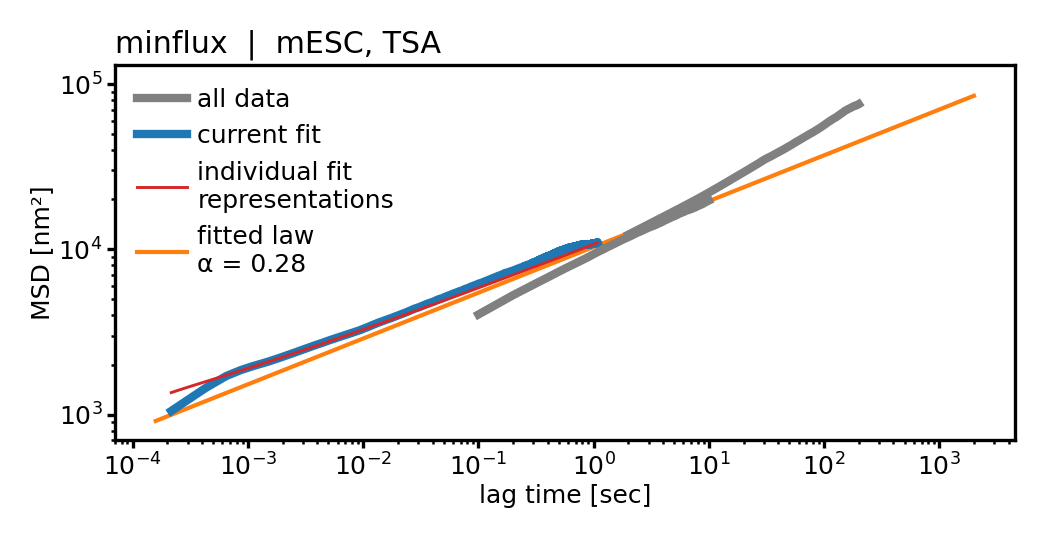

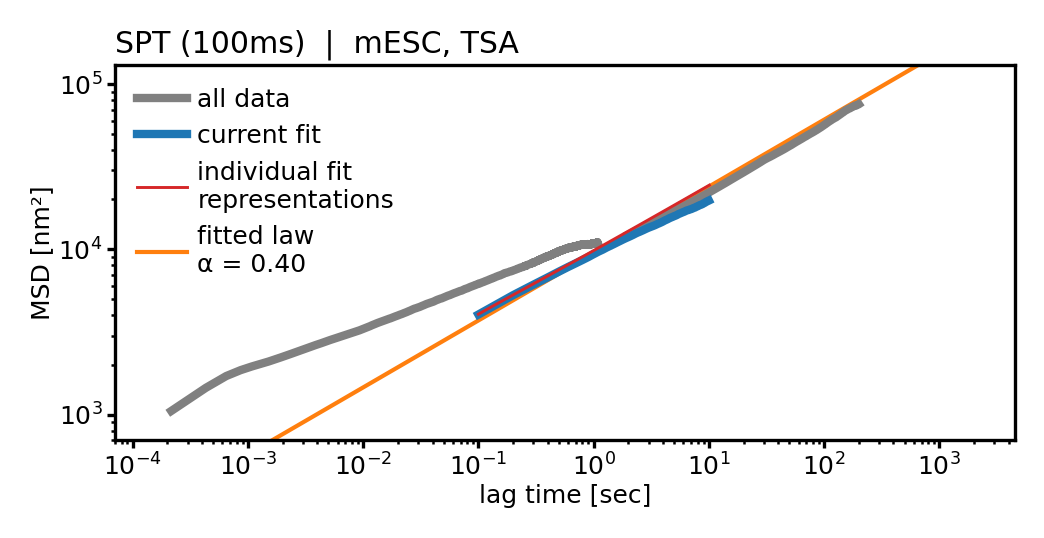

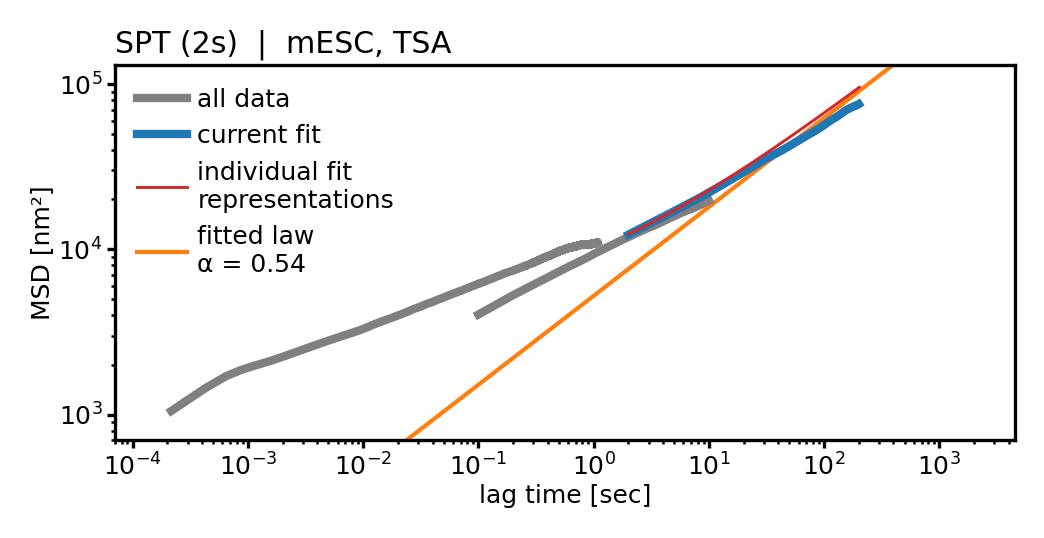

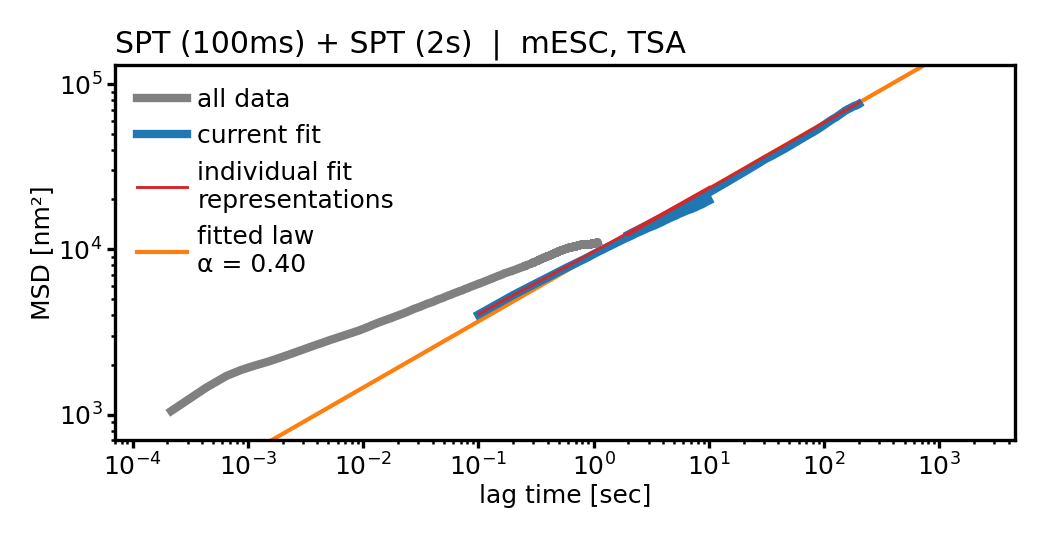

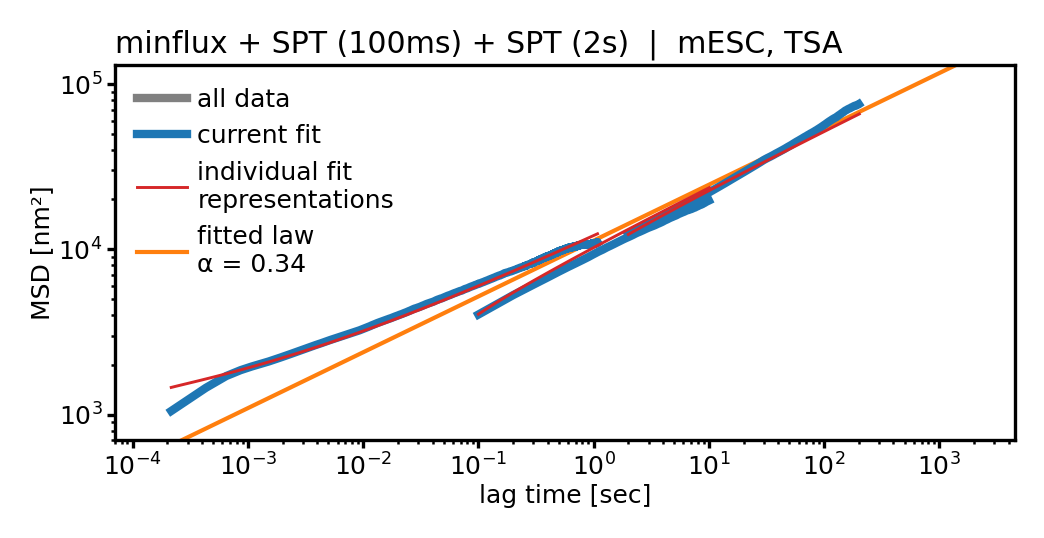

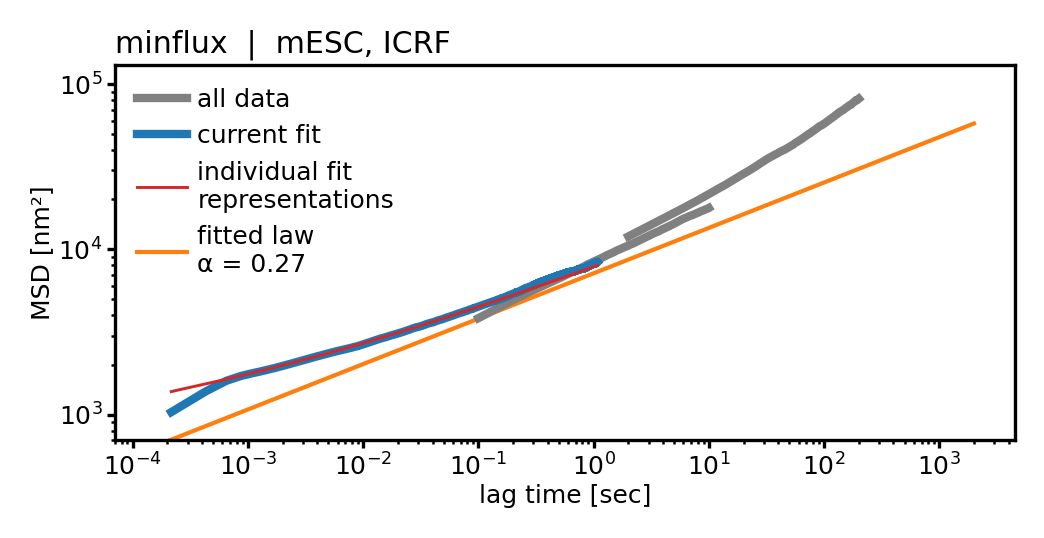

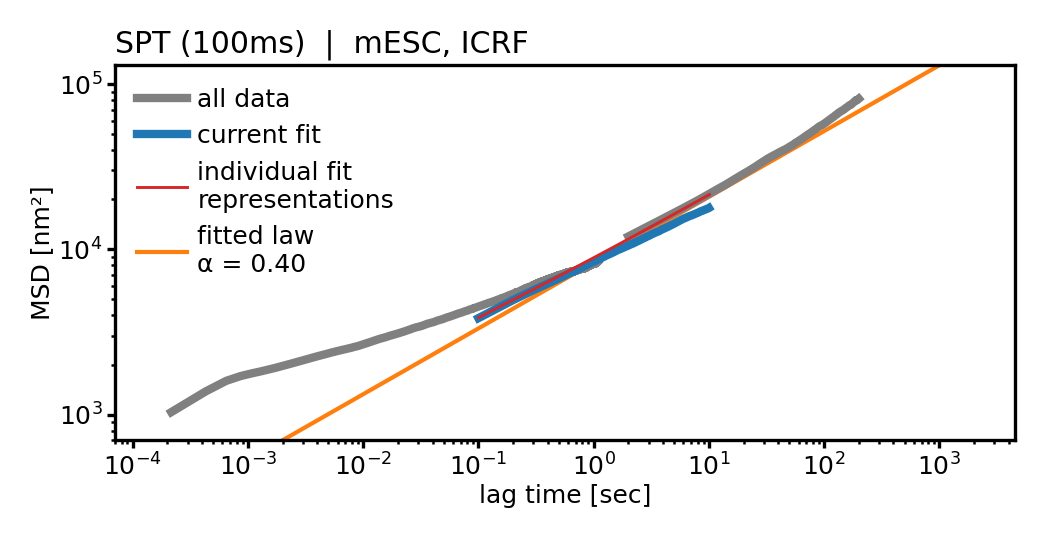

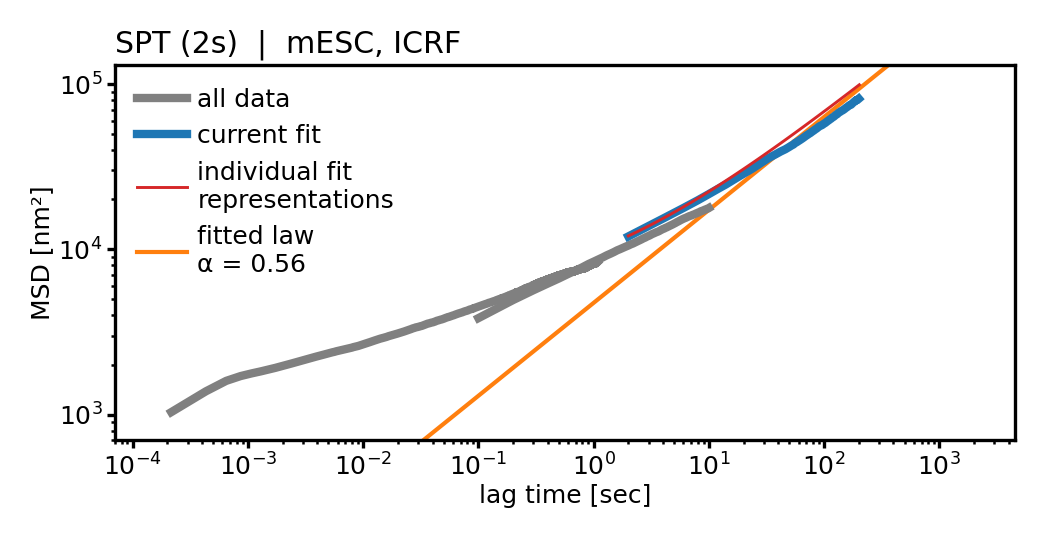

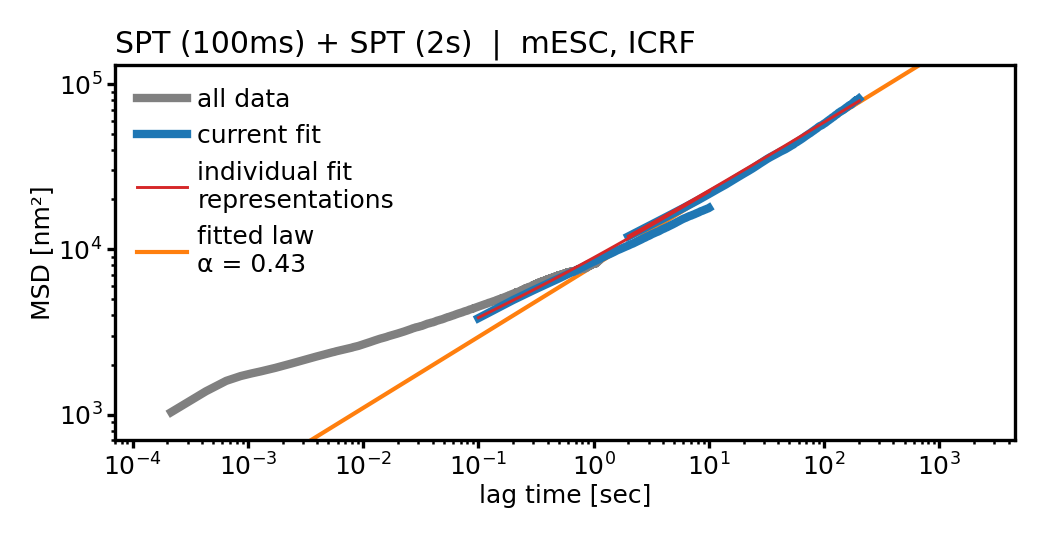

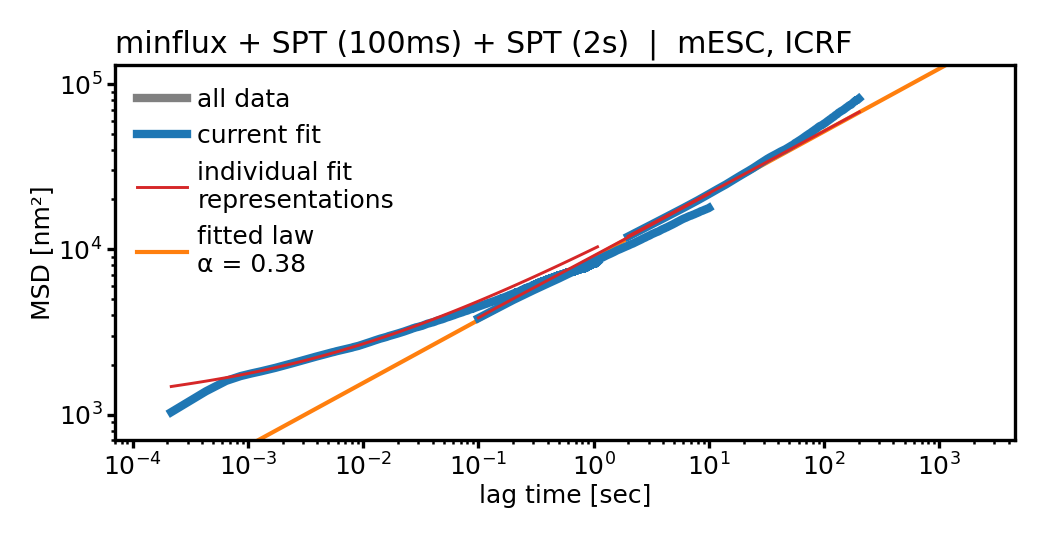

In [22]:
ct = 'mESC'

for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:

    cond = ', '.join(['H2B', ct, treatment])
    fitres = nl.io.load.hdf5(f'20250327_no-kink_fitres_NPFit-aGparam_{ct}.h5')[treatment]

    fits = {
        'single' : {},
        'joints' : {},
    }
    
    dummy_data = nl.TaggedSet([nl.Trajectory([[0, 0]])], hasTags=False)

    # Minflux
    data.makeSelection('minflux-H2B')
    dt_H2B = data[0].meta['Δt']

    fit = bayesmsd.lib.NPFit(dummy_data, motion_blur_f=dt_H2B, parametrization='(log(αΓ), α)')
    fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
    fits['single'][f'minflux'] = fit

    # Conventional
    tau_e = 0.08671
    fit = bayesmsd.lib.NPFit(dummy_data, motion_blur_f=tau_e, parametrization='(log(αΓ), α)')
    fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
    fits['single'][f'SPT-100ms'] = fit
    fits['single'][f'SPT-2s'] = fit

    # Assemble list of fit(group)s
    groups = {
        'minflux'       : ['minflux'],
        'SPT 100ms'     : ['SPT-100ms'],
        'SPT 2s'        : ['SPT-2s'],
        'SPT'           : ['SPT-100ms', 'SPT-2s'],
        'minflux + SPT' : ['minflux', 'SPT-100ms', 'SPT-2s'],
    }

    ### Plotting ###

    tmax = {
        'minflux'   : 5001,
        'SPT 100ms' : 101,
        'SPT 2s'    : 101,
        'Fbn2'      : 101,
    }
    dts = {
        'minflux'   : dt_H2B,
        'SPT 100ms' : 0.1,
        'SPT 2s'    : 2,
        'Fbn2'      : 20,
    }
    title_dict = {
        'minflux'       : 'minflux',
        'SPT 100ms'     : 'SPT (100ms)',
        'SPT 2s'        : 'SPT (2s)',
        'SPT'           : 'SPT (100ms) + SPT (2s)',
        'minflux + SPT' : 'minflux + SPT (100ms) + SPT (2s)',
    }

    kwargs           = dict(color='gray',       zorder=9,  linewidth=2)
    kwargs_highlight = dict(color='tab:blue',   zorder=10, linewidth=2)
    kwargs_law       = dict(color='tab:orange', zorder=0,  linewidth=1)
    kwargs_repr      = dict(color='tab:red',    zorder=11, linewidth=0.7)

    for i_save, resname in enumerate(title_dict): # preserves order
        fitnames = groups[resname]
        plt.figure(figsize=[6, 2.5])

        # minflux
        kw = kwargs_highlight if any(['minflux' in name for name in fitnames]) else kwargs
        data.makeSelection(['minflux', cond], logic=all)
        dt = data[0].meta['Δt']

        msd = nl.analysis.MSD(data)
        msd *= 1e18 # nm²
        plt.plot(dt*np.arange(1, tmax['minflux']), msd[1:tmax['minflux']], **kw)

        # SPT
        for dt_tag in ['100ms', '2s']:
            kw = kwargs_highlight if 'SPT-'+dt_tag in fitnames else kwargs
            data.makeSelection(['SPT', dt_tag, cond], logic=all)
            dt = data[0].meta['Δt']

            msd = nl.analysis.MSD(data)
            msd /= 2   # 2-loc
            msd *= 1e6 # nm²
            plt.plot(dt*np.arange(1, tmax['SPT '+dt_tag]), msd[1:tmax['SPT '+dt_tag]], **kw)

        # Fbn2
        if cond == 'H2B, mESC, ctrl' and False:
            raise NotImplementedError # review code below, not used yet

            kw = kwargs_highlight if any(['Fbn2' in name for name in fitnames]) else kwargs

            data.makeSelection('C36')

            msd = nl.analysis.MSD(data_fbn2)
            msd /= 2   # 2-loc
            msd *= 2/3 # 3D --> 2D
            msd *= 1e6 # nm²
            dt = 20
            plt.plot(dt*np.arange(1, tmax['Fbn2']), msd[1:tmax['Fbn2']], **kw)

        # fitres singles
        for fitname in fitnames:
            fit = fits['single'][fitname]
            params = {key[(len(fitname)+1):] : val
                      for key, val in fitres[resname]['params'].items()
                      if key.startswith(fitname)
                     }
            params = fit.fill_dependent_params(params)

            key = 'minflux'
            if fitname.startswith('SPT'):
                dt_tag = fitname[len('SPT-'):]
                key = 'SPT '+dt_tag

            xplot = dts[key] * np.logspace(0, np.log10(tmax[key]), 100)
            msd = fit.MSD(params, dt=xplot)
            msd *= 1e6     # nm²
            if key != 'minflux':
                msd /= 2   # 2-loc

            plt.plot(xplot, msd, **kwargs_repr)

        # fitres law
        a     = fitres[resname]['params']['α']
        logaG = fitres[resname]['params']['log(αΓ)']

        G_1D = np.exp(logaG)/a
        G_1D *= 1e6 # nm²

        xplot = np.logspace(-3.8, 3.3, 100)
        plt.plot(xplot, 2*G_1D*xplot**a, **kwargs_law)

        # Plot properties
        plt.plot(0, 0, **kwargs,           label='all data')
        plt.plot(0, 0, **kwargs_highlight, label='current fit')
        plt.plot(0, 0, **kwargs_repr,      label='individual fit\nrepresentations')
        plt.plot(0, 0, **kwargs_law,       label='fitted law\nα = '+f'{a:.2f}')
        plt.legend(loc='upper left')

        plt.title(title_dict[resname]+f'  |  {ct}, {treatment}')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('lag time [sec]')
        plt.ylabel('MSD [nm²]')
        plt.ylim([7e2, 1.3e5])

    #     # Show localization errors
    #     ax = plt.gca().inset_axes([0.6, 0.2, 0.3, 0.5])
    #     log_s2 = {'minflux' : np.nan, 'SPT 100ms' : np.nan, 'SPT 2s' : np.nan}
    #     refnames = {
    #         'minflux'   : 'minflux_cgdt0',
    #         'SPT 100ms' : 'conventional_100ms',
    #         'SPT 2s'    : 'conventional_2s',
    #     }
    #     for key in refnames:
    #         if refnames[key] in fitnames:
    #             log_s2[key] = fitres[resname]['params'][refnames[key]+' log(σ²) (dim 0)']
    #     
    #     for i, key in enumerate(log_s2):
    #         s = np.sqrt(np.exp(log_s2[key])) * 1e3 # nm
    #         if key != 'minflux':
    #             s /= np.sqrt(2) # 2-loc
    #         
    #         ax.bar(i, s, color=highlight_kwargs['color'])
    #     
    #     ax.set_xticks([0, 1, 2], labels=['minflux', 'SPT\n100ms', 'SPT\n2s'])
    #     ax.set_xlim([-0.5, 2.5])
    #     ax.set_ylim([0, 40])
    #     ax.yaxis.tick_right()
    #     ax.yaxis.set_label_position('right')
    #     ax.spines['top'].set_visible(False)
    #     ax.spines['left'].set_visible(False)
    #     ax.set_ylabel('spot error [nm]')
    #     ax.set_facecolor((1., 1., 1., 0.))

        plt.savefig(f'piecewise_fit_plots_no-kink/{ct}_{treatment}_{i_save}.pdf')
        plt.show()

# For Johannstadt talk

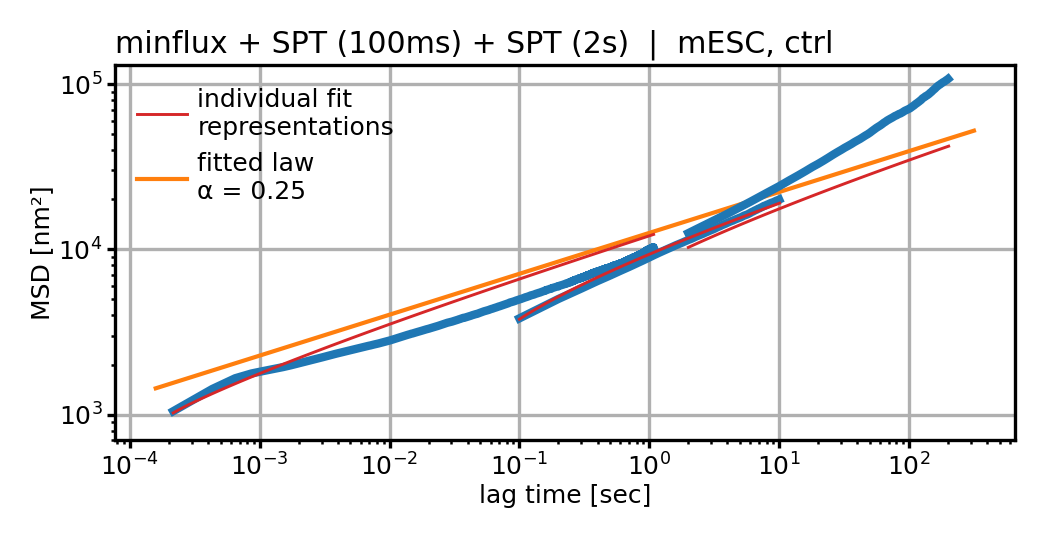

In [20]:
ct = 'mESC'

for treatment in ['ctrl']:#, 'DRB', 'TSA', 'ICRF']:

    cond = ', '.join(['H2B', ct, treatment])
    fitres = nl.io.load.hdf5(f'20250227_fitres_NPFit-partials_{ct}-{treatment}.h5')

    fits = {
        'single' : {},
        'joints' : {},
    }
    
    dummy_data = nl.TaggedSet([nl.Trajectory([[0, 0]])], hasTags=False)

    # Minflux
    data.makeSelection('minflux-H2B')
    dt_H2B = data[0].meta['Δt']

    fit = bayesmsd.lib.NPFit(dummy_data, motion_blur_f=dt_H2B, parametrization='(log(Γ), α)')
    fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
    fits['single'][f'minflux'] = fit

    # Conventional
    tau_e = 0.08671
    fit = bayesmsd.lib.NPFit(dummy_data, motion_blur_f=tau_e, parametrization='(log(Γ), α)')
    fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
    fits['single'][f'SPT-100ms'] = fit
    fits['single'][f'SPT-2s'] = fit

    # Assemble list of fit(group)s
    groups = {
        'minflux'       : ['minflux'],
        'SPT 100ms'     : ['SPT-100ms'],
        'SPT 2s'        : ['SPT-2s'],
        'SPT'           : ['SPT-100ms', 'SPT-2s'],
        'minflux + SPT' : ['minflux', 'SPT-100ms', 'SPT-2s'],
    }

    ### Plotting ###

    tmax = {
        'minflux'   : 5001,
        'SPT 100ms' : 101,
        'SPT 2s'    : 101,
        'Fbn2'      : 101,
    }
    dts = {
        'minflux'   : dt_H2B,
        'SPT 100ms' : 0.1,
        'SPT 2s'    : 2,
        'Fbn2'      : 20,
    }
    title_dict = {
        # 'minflux'       : 'minflux',
        # 'SPT 100ms'     : 'SPT (100ms)',
        # 'SPT 2s'        : 'SPT (2s)',
        # 'SPT'           : 'SPT (100ms) + SPT (2s)',
        'minflux + SPT' : 'minflux + SPT (100ms) + SPT (2s)',
    }

    kwargs           = dict(color='gray',       zorder=9,  linewidth=2)
    kwargs_highlight = dict(color='tab:blue',   zorder=10, linewidth=2)
    kwargs_law       = dict(color='tab:orange', zorder=5,  linewidth=1)
    kwargs_repr      = dict(color='tab:red',    zorder=11, linewidth=0.7)

    for i_save, resname in enumerate(title_dict): # preserves order
        fitnames = groups[resname]
        plt.figure(figsize=[6, 2.5])

        # minflux
        kw = kwargs_highlight if any(['minflux' in name for name in fitnames]) else kwargs
        data.makeSelection(['minflux', cond], logic=all)
        dt = data[0].meta['Δt']

        msd = nl.analysis.MSD(data)
        msd *= 1e18 # nm²
        plt.plot(dt*np.arange(1, tmax['minflux']), msd[1:tmax['minflux']], **kw)

        # SPT
        for dt_tag in ['100ms', '2s']:
            kw = kwargs_highlight if 'SPT-'+dt_tag in fitnames else kwargs
            data.makeSelection(['SPT', dt_tag, cond], logic=all)
            dt = data[0].meta['Δt']

            msd = nl.analysis.MSD(data)
            msd /= 2   # 2-loc
            msd *= 1e6 # nm²
            plt.plot(dt*np.arange(1, tmax['SPT '+dt_tag]), msd[1:tmax['SPT '+dt_tag]], **kw)

        # Fbn2
        if cond == 'H2B, mESC, ctrl' and False:
            raise NotImplementedError # review code below, not used yet

            kw = kwargs_highlight if any(['Fbn2' in name for name in fitnames]) else kwargs

            data.makeSelection('C36')

            msd = nl.analysis.MSD(data_fbn2)
            msd /= 2   # 2-loc
            msd *= 2/3 # 3D --> 2D
            msd *= 1e6 # nm²
            dt = 20
            plt.plot(dt*np.arange(1, tmax['Fbn2']), msd[1:tmax['Fbn2']], **kw)

        # fitres singles
        for fitname in fitnames:
            fit = fits['single'][fitname]
            if fitname == 'minflux':
                fitname = 'minflux_cgdt0'
            if fitname.startswith('SPT'):
                fitname = 'conventional_'+fitname.split('-')[-1]
                
            params = {key[(len(fitname)+1):] : val
                      for key, val in fitres[resname]['params'].items()
                      if key.startswith(fitname)
                     }
            params = fit.fill_dependent_params(params)

            key = 'minflux'
            if fitname.startswith('conventional'):
                dt_tag = fitname[len('conventional_'):]
                key = 'SPT '+dt_tag

            xplot = dts[key] * np.logspace(0, np.log10(tmax[key]), 100)
            msd = fit.MSD(params, dt=xplot)
            msd *= 1e6     # nm²
            if key != 'minflux':
                msd /= 2   # 2-loc

            plt.plot(xplot, msd, **kwargs_repr)

        # fitres law
        a     = fitres[resname]['params']['α']
        logG  = fitres[resname]['params']['log(Γ)']

        G_1D = np.exp(logG)
        G_1D *= 1e6 # nm²

        xplot = np.logspace(-3.8, 2.5, 100)
        plt.plot(xplot, 2*G_1D*xplot**a, **kwargs_law)

        # Plot properties
        # plt.plot(0, 0, **kwargs,           label='all data')
        # plt.plot(0, 0, **kwargs_highlight, label='current fit')
        plt.plot(0, 0, **kwargs_repr,      label='individual fit\nrepresentations')
        plt.plot(0, 0, **kwargs_law,       label='fitted law\nα = '+f'{a:.2f}')
        plt.legend(loc='upper left')

        plt.title(title_dict[resname]+f'  |  {ct}, {treatment}')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('lag time [sec]')
        plt.ylabel('MSD [nm²]')
        plt.ylim([7e2, 1.3e5])

    #     # Show localization errors
    #     ax = plt.gca().inset_axes([0.6, 0.2, 0.3, 0.5])
    #     log_s2 = {'minflux' : np.nan, 'SPT 100ms' : np.nan, 'SPT 2s' : np.nan}
    #     refnames = {
    #         'minflux'   : 'minflux_cgdt0',
    #         'SPT 100ms' : 'conventional_100ms',
    #         'SPT 2s'    : 'conventional_2s',
    #     }
    #     for key in refnames:
    #         if refnames[key] in fitnames:
    #             log_s2[key] = fitres[resname]['params'][refnames[key]+' log(σ²) (dim 0)']
    #     
    #     for i, key in enumerate(log_s2):
    #         s = np.sqrt(np.exp(log_s2[key])) * 1e3 # nm
    #         if key != 'minflux':
    #             s /= np.sqrt(2) # 2-loc
    #         
    #         ax.bar(i, s, color=highlight_kwargs['color'])
    #     
    #     ax.set_xticks([0, 1, 2], labels=['minflux', 'SPT\n100ms', 'SPT\n2s'])
    #     ax.set_xlim([-0.5, 2.5])
    #     ax.set_ylim([0, 40])
    #     ax.yaxis.tick_right()
    #     ax.yaxis.set_label_position('right')
    #     ax.spines['top'].set_visible(False)
    #     ax.spines['left'].set_visible(False)
    #     ax.set_ylabel('spot error [nm]')
    #     ax.set_facecolor((1., 1., 1., 0.))

        plt.grid('on')
        plt.savefig('mESC_for_Johannstadt.pdf')
        plt.show()